In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy

from bow_word2vec import train_loader, test_loader, data_loader

from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/common/home/wcc44/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/common/home/wcc44/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to
[nltk_data]     /common/home/wcc44/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65


/common/home/wcc44/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            # nn.ReLU(),
            # nn.Linear(1000, 500),
            # nn.ReLU(),
            # nn.Linear(500, 100),
            # nn.ReLU(),
            # nn.Linear(100, 50),
            # nn.ReLU(),
            # nn.Linear(50, 50),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
)


In [13]:
#NN Model
# Training loop
#model = NeuralNetwork().to(device)

num_epochs = 30

personalities = sorted([
    # Authors
    "William Shakespeare", "Jane Austen", "George Orwell", "J.K. Rowling",
    "Ernest Hemingway", "Mark Twain", "Charles Dickens", "Leo Tolstoy",
    "Agatha Christie", "Virginia Woolf",
    "Haruki Murakami", "Gabriel García Márquez", "Toni Morrison", "Franz Kafka",
    "Fyodor Dostoevsky", "James Baldwin", "Chimamanda Ngozi Adichie", "Salman Rushdie",
    "Octavia E. Butler", "Langston Hughes",

    # Politicians
    "Nelson Mandela", "Winston Churchill", "Margaret Thatcher", "Barack Obama",
    "Mahatma Gandhi", "Angela Merkel", "Abraham Lincoln", "John F. Kennedy",
    "Vladimir Putin", "Xi Jinping",
    "Franklin D. Roosevelt", "Indira Gandhi", "Simón Bolívar", "Benazir Bhutto",
    "Theodore Roosevelt", "Emmanuel Macron", "Jacinda Ardern", "Luiz Inácio Lula da Silva",
    "Aung San Suu Kyi",

    # Musicians
    "Ludwig van Beethoven", "Wolfgang Amadeus Mozart", "Bob Dylan", "The Beatles",
    "Michael Jackson", "Madonna", "Beyoncé", "David Bowie", "Elvis Presley",
    "Freddie Mercury",
    "Prince", "Aretha Franklin", "Johann Sebastian Bach", "Amy Winehouse",
    "Tupac Shakur", "Lady Gaga", "Bob Marley", "Nina Simone", "Jimi Hendrix",
    "Whitney Houston",

    # Historical Figures
    "Albert Einstein", "Martin Luther King Jr.", "Leonardo da Vinci", "Cleopatra",
    "Julius Caesar", "Joan of Arc", "Galileo Galilei", "Isaac Newton",
    "Napoleon Bonaparte", "Alexander the Great",
    "Confucius", "Socrates", "Marie Curie", "Genghis Khan", "Rosa Parks",
    "Queen Elizabeth I", "Charles Darwin", "Harriet Tubman", "Sigmund Freud",
    "Anne Frank",

    # Actors
    "Marilyn Monroe", "Audrey Hepburn", "Marlon Brando", "Meryl Streep",
    "Leonardo DiCaprio", "Denzel Washington", "Tom Hanks", "Natalie Portman",
    "Brad Pitt", "Angelina Jolie",
    "Sidney Poitier", "Cate Blanchett", "Daniel Day-Lewis", "Viola Davis",
    "Heath Ledger", "Charlize Theron", "Joaquin Phoenix", "Lupita Nyong'o",
    "Keanu Reeves", "Saoirse Ronan",

    #Other
    "Simón Bolívar"
])

# Define personalities_to_int dictionary outside the loop
personalities_to_int = {personality: i for i, personality in enumerate(sorted(set(personalities)))}

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (text, labels, vector) in enumerate(train_loader):
        # Encode labels
        numerical_labels = [personalities_to_int[label] for label in labels]
        num_labels = torch.tensor(numerical_labels)

        # Forward pass
        outputs = model(vector.float())
        loss = criterion(outputs, num_labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()


    print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    #print(f"Loss: {running_loss / len(train_loader)}")

KeyboardInterrupt: 

Accuracy: 0.03


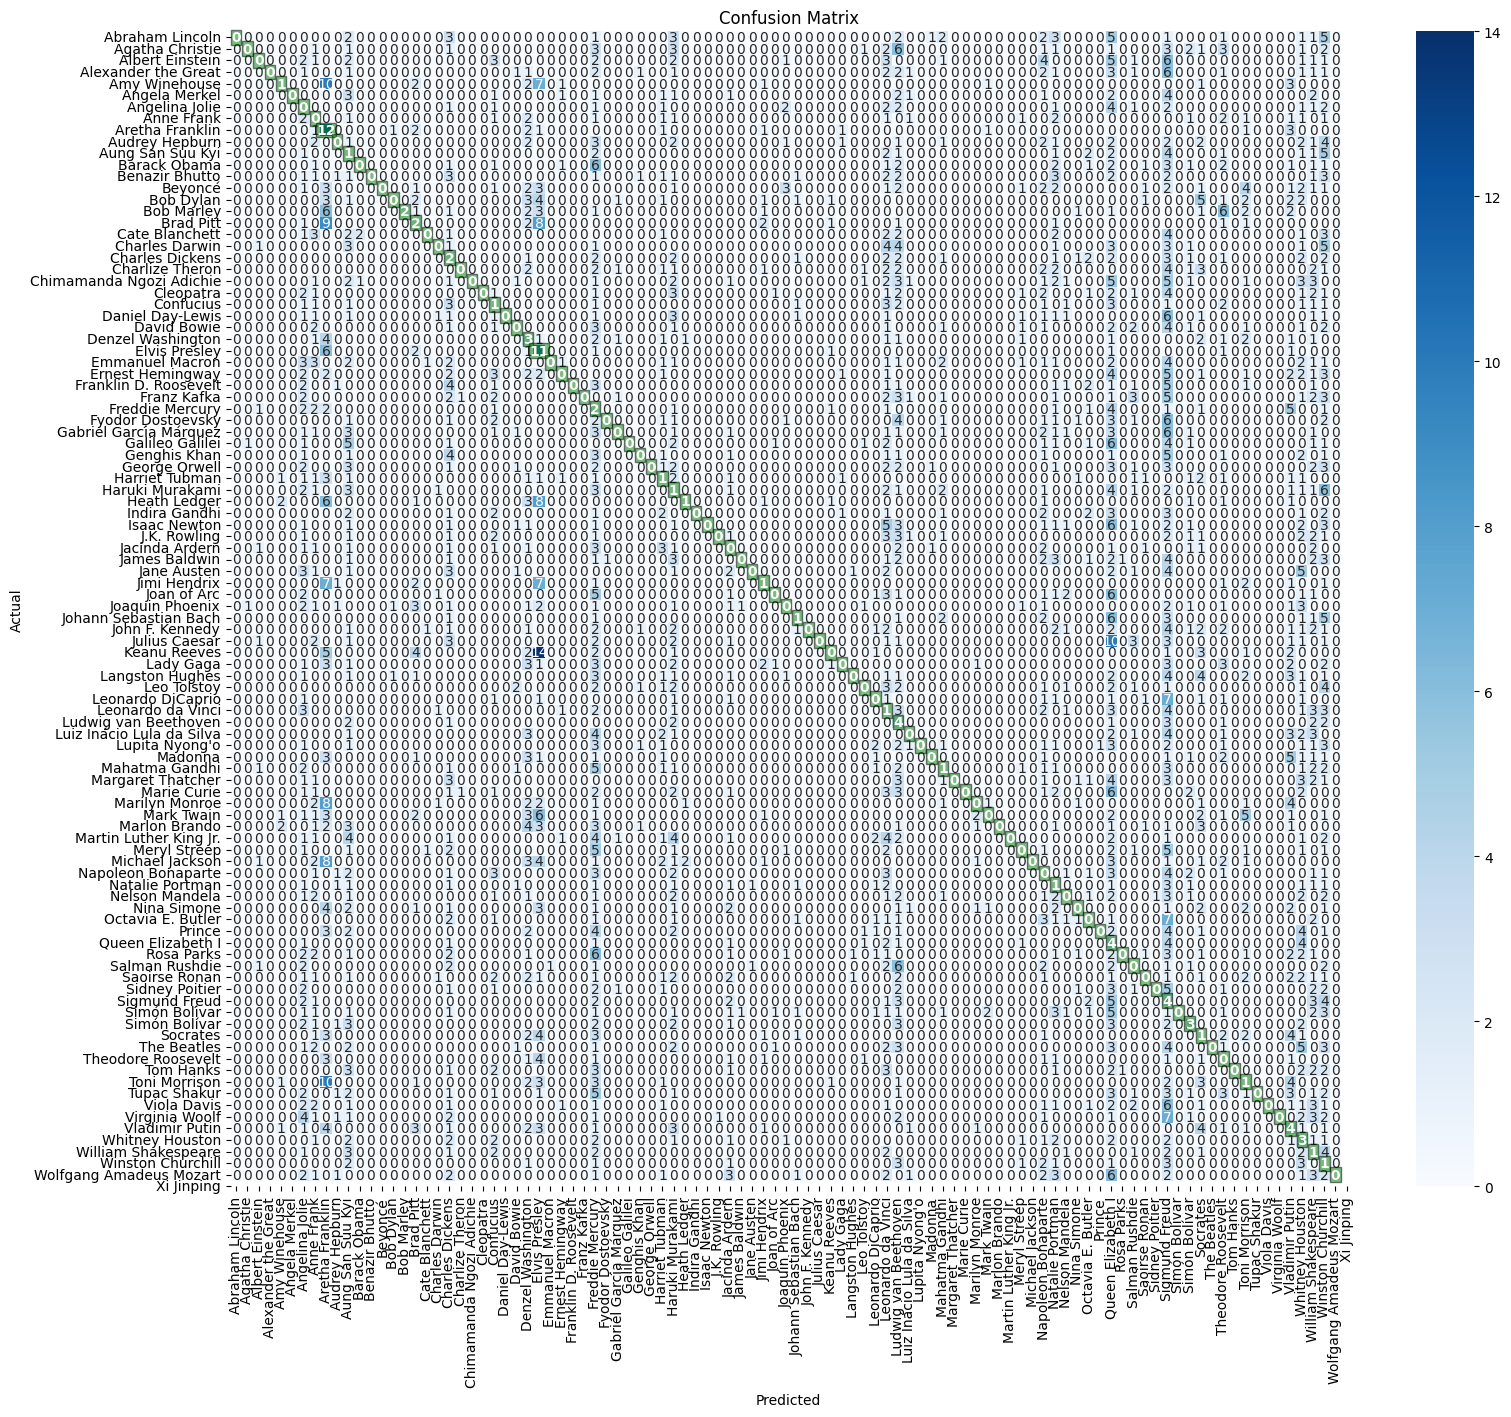

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Set model to evaluation mode
model.eval()

# Lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Define the personalities in alphabetical order
personalities = sorted([
    # Authors
    "William Shakespeare", "Jane Austen", "George Orwell", "J.K. Rowling",
    "Ernest Hemingway", "Mark Twain", "Charles Dickens", "Leo Tolstoy",
    "Agatha Christie", "Virginia Woolf",
    "Haruki Murakami", "Gabriel García Márquez", "Toni Morrison", "Franz Kafka",
    "Fyodor Dostoevsky", "James Baldwin", "Chimamanda Ngozi Adichie", "Salman Rushdie",
    "Octavia E. Butler", "Langston Hughes",

    # Politicians
    "Nelson Mandela", "Winston Churchill", "Margaret Thatcher", "Barack Obama",
    "Mahatma Gandhi", "Angela Merkel", "Abraham Lincoln", "John F. Kennedy",
    "Vladimir Putin", "Xi Jinping",
    "Franklin D. Roosevelt", "Indira Gandhi", "Simón Bolívar", "Benazir Bhutto",
    "Theodore Roosevelt", "Emmanuel Macron", "Jacinda Ardern", "Luiz Inácio Lula da Silva",
    "Aung San Suu Kyi",

    # Musicians
    "Ludwig van Beethoven", "Wolfgang Amadeus Mozart", "Bob Dylan", "The Beatles",
    "Michael Jackson", "Madonna", "Beyoncé", "David Bowie", "Elvis Presley",
    "Freddie Mercury",
    "Prince", "Aretha Franklin", "Johann Sebastian Bach", "Amy Winehouse",
    "Tupac Shakur", "Lady Gaga", "Bob Marley", "Nina Simone", "Jimi Hendrix",
    "Whitney Houston",

    # Historical Figures
    "Albert Einstein", "Martin Luther King Jr.", "Leonardo da Vinci", "Cleopatra",
    "Julius Caesar", "Joan of Arc", "Galileo Galilei", "Isaac Newton",
    "Napoleon Bonaparte", "Alexander the Great",
    "Confucius", "Socrates", "Marie Curie", "Genghis Khan", "Rosa Parks",
    "Queen Elizabeth I", "Charles Darwin", "Harriet Tubman", "Sigmund Freud",
    "Anne Frank",

    # Actors
    "Marilyn Monroe", "Audrey Hepburn", "Marlon Brando", "Meryl Streep",
    "Leonardo DiCaprio", "Denzel Washington", "Tom Hanks", "Natalie Portman",
    "Brad Pitt", "Angelina Jolie",
    "Sidney Poitier", "Cate Blanchett", "Daniel Day-Lewis", "Viola Davis",
    "Heath Ledger", "Charlize Theron", "Joaquin Phoenix", "Lupita Nyong'o",
    "Keanu Reeves", "Saoirse Ronan",

    #Other
    "Simón Bolívar"
])

# Define personalities_to_int dictionary outside the loop
personalities_to_int = {personality: i for i, personality in enumerate(personalities)}

# Iterate through the test dataset
for data, labels, vector in test_loader:
    # Forward pass
    outputs = model(vector.float())
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)

    # Encode labels
    numerical_labels = [personalities_to_int[label] for label in labels]
    num_labels = torch.tensor(numerical_labels)
    
    # Convert to numpy arrays
    actual_labels.extend(num_labels.numpy())
    predicted_labels.extend(predicted.numpy())

# Ensure actual and predicted labels have the same length
#assert len(actual_labels) == len(predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Get class labels in alphabetical order
class_labels = sorted(personalities_to_int.keys())
class_labels = personalities_to_int.keys()

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

# Output accuracy
print(f"Accuracy: {accuracy:.2f}")

# Plot confusion matrix with highlighting correct predictions on the diagonal
plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Highlight correct predictions on the diagonal
for i in range(min(len(class_labels), conf_matrix.shape[0])):
    plt.text(i + 0.5, i + 0.5, f'{conf_matrix[i, i]}', ha='center', va='center', color='white', fontsize=10, fontweight='bold', bbox=dict(facecolor='green', alpha=0.5, pad=0.3))

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# print(list(personalities_to_int.keys())[list(personalities_to_int.values()).index(0)])
pred_classes = []
for pred_label in predicted_labels:
    pred_classes.append(list(personalities_to_int.keys())[list(personalities_to_int.values()).index(pred_label)])
pred_classes_count = []
for personality in personalities:
    pred_classes_count.append(pred_classes.count(personality))

act_classes = []
for act_label in actual_labels:
    act_classes.append(list(personalities_to_int.keys())[list(personalities_to_int.values()).index(act_label)])

act_classes_count = []
for personality in personalities:
    act_classes_count.append(act_classes.count(personality))

# for i in range(len(personalities)):
#     print("Personality: ", personalities[i], " Num Predicted: ", pred_classes_count[i], " Num Actual: ", act_classes_count[i], " Ratio: ", pred_classes_count[i]/act_classes_count[i])

pred_ratios = []
for i in range(len(personalities)):
    # x = []
    # x.append(personalities[i])
    # x.append(pred_classes_count[i]/act_classes_count[i])
    # pred_ratios.append(x)
    if act_classes_count[i] == 0:
        pred_ratios.append(1)
    elif act_classes_count[i] != 0:
        pred_ratios.append(pred_classes_count[i]/act_classes_count[i])
    else:
        pred_ratios.append(int(-act_classes_count[i]))

pred_dict = {}
for key in personalities:
    for value in pred_ratios:
        pred_dict[key] = value
        pred_ratios.remove(value)
        break

#pred_dict[max(pred_dict, key=pred_dict.get)]


In [11]:
print("Max predicted: ")
max_pred = sorted(pred_dict, key=pred_dict.get, reverse=True)[:10]

for personality in max_pred:
    print(personality, " ", pred_dict[personality])

Max predicted: 
Queen Elizabeth I   9.80952380952381
Sigmund Freud   9.0
Wolfgang Amadeus Mozart   7.0
Ludwig van Beethoven   6.888888888888889
Freddie Mercury   6.333333333333333
Aretha Franklin   4.888888888888889
Elvis Presley   4.36
William Shakespeare   3.9615384615384617
Aung San Suu Kyi   3.9583333333333335
Angelina Jolie   3.8636363636363638


In [12]:
print("Min predicted: ")
min_pred = sorted(pred_dict, key=pred_dict.get, reverse=False)[:10]

for personality in min_pred:
    print(personality, " ", pred_dict[personality])

Min predicted: 
Abraham Lincoln   0.0
Alexander the Great   0.0
Angela Merkel   0.0
Benazir Bhutto   0.0
Beyoncé   0.0
Chimamanda Ngozi Adichie   0.0
Cleopatra   0.0
Daniel Day-Lewis   0.0
Franklin D. Roosevelt   0.0
Franz Kafka   0.0


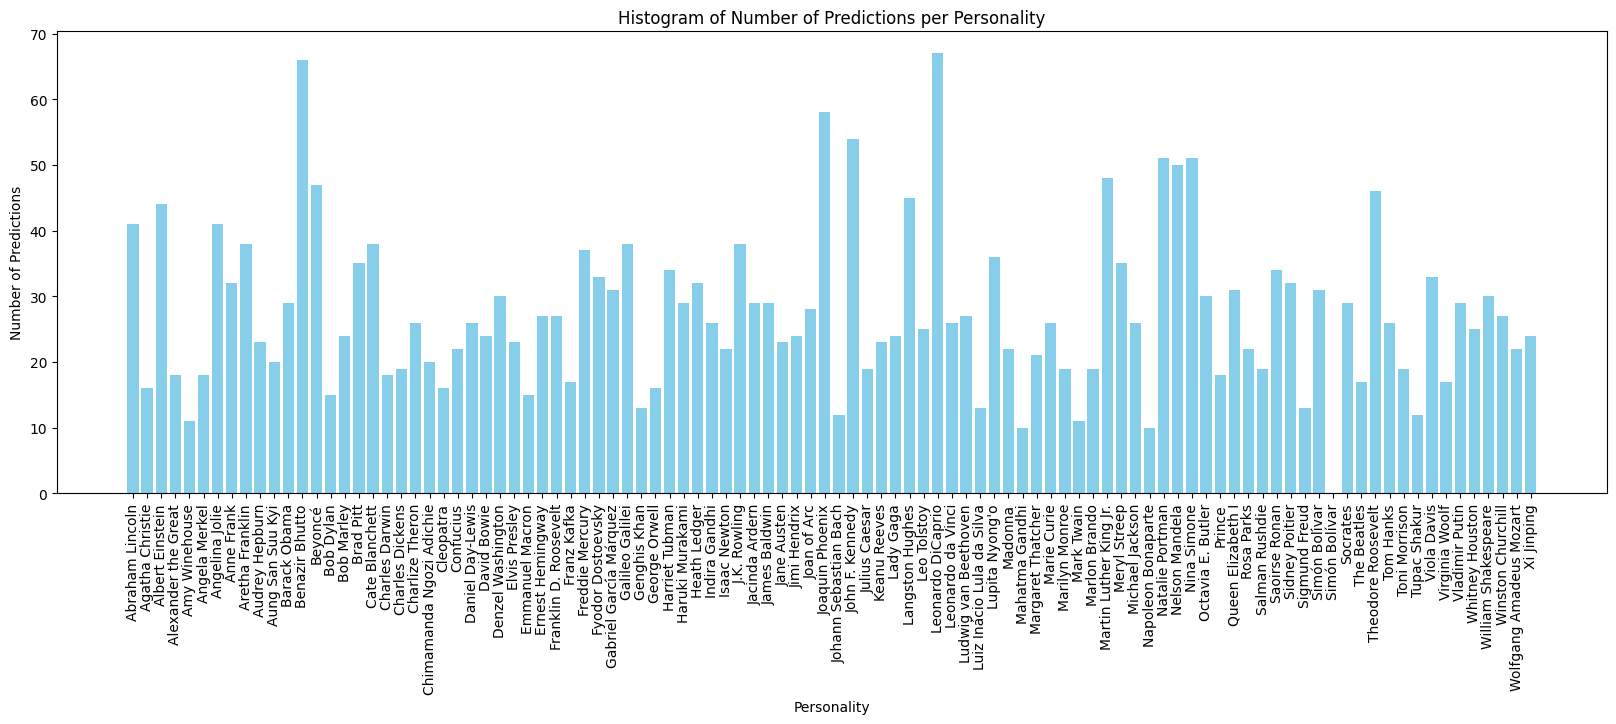

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Convert predicted_labels to a NumPy array
predicted_labels_np = np.array(predicted_labels)

# Count the number of predictions for each personality
predictions_count = {personality: np.sum(predicted_labels_np == personalities_to_int[personality]) for personality in personalities}

# Sort predictions_count by keys (personality names)
sorted_predictions_count = dict(sorted(predictions_count.items()))

# Plot histogram
plt.figure(figsize=(20, 6))
plt.bar(sorted_predictions_count.keys(), sorted_predictions_count.values(), color='skyblue')
plt.xlabel('Personality')
plt.ylabel('Number of Predictions')
plt.title('Histogram of Number of Predictions per Personality')
plt.xticks(rotation=90)
plt.show()

